In [65]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
csv_path = "C:/Users/USER/.keras/datasets/jena_climate_2009_2016.csv"

In [3]:
df = pd.read_csv(csv_path)

- step=10min

In [4]:
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10


In [5]:
df1 = df[5::6]

- step=1h

In [6]:
df1.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30


In [7]:
pd.to_datetime(df1["Date Time"], format="%d.%m.%Y %H:%M:%S")

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [8]:
df2 = df1.set_index(pd.to_datetime(df1.pop("Date Time"), format="%d.%m.%Y %H:%M:%S"))

In [9]:
df2.index

DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00', '2009-01-01 06:00:00',
               '2009-01-01 07:00:00', '2009-01-01 08:00:00',
               '2009-01-01 09:00:00', '2009-01-01 10:00:00',
               ...
               '2016-12-31 14:10:00', '2016-12-31 15:10:00',
               '2016-12-31 16:10:00', '2016-12-31 17:10:00',
               '2016-12-31 18:10:00', '2016-12-31 19:10:00',
               '2016-12-31 20:10:00', '2016-12-31 21:10:00',
               '2016-12-31 22:10:00', '2016-12-31 23:10:00'],
              dtype='datetime64[ns]', name='Date Time', length=70091, freq=None)

In [10]:
n = len(df2)
train_df = df2.iloc[: int(n*0.7)]
val_df = df2.iloc[int(n*0.7): int(n*0.9)]
test_df = df2.iloc[int(n*0.9):]

train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
train_df.describe().transpose().loc[:, ["mean", "std"]]

,mean,std
p (mbar),0.00,1.00
T (degC),-0.00,1.00
Tpot (K),0.00,1.00
Tdew (degC),0.00,1.00
rh (%),-0.00,1.00
VPmax (mbar),0.00,1.00
VPact (mbar),-0.00,1.00
VPdef (mbar),0.00,1.00
sh (g/kg),-0.00,1.00
H2OC (mmol/mol),0.00,1.00


In [12]:
input_width = 6
label_width = 1
shift = 1

total_window_size = input_width + label_width 
print(np.arange(total_window_size))

input_slice = slice(0, input_width)
print(np.arange(total_window_size)[input_slice])
input_indices = np.arange(total_window_size)[input_slice]


#label_slice = slice(0,, label_width)
label_start = total_window_size - label_width
labels_slice = slice(label_start, None)
print(np.arange(total_window_size)[labels_slice])
label_indices = np.arange(total_window_size)[labels_slice]

[0 1 2 3 4 5 6]
[0 1 2 3 4 5]
[6]


In [13]:
train_df[: total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,0.95,-1.98,-2.04,-1.92,1.12,-1.30,-1.48,-0.79,-1.48,-1.48,2.22,-1.27,-1.26,0.22
2009-01-01 02:00:00,0.96,-2.08,-2.14,-2.06,1.04,-1.33,-1.53,-0.79,-1.54,-1.54,2.33,-1.24,-1.26,0.19
2009-01-01 03:00:00,0.99,-2.07,-2.13,-2.05,1.06,-1.33,-1.53,-0.79,-1.53,-1.53,2.32,-1.29,-1.26,-0.07
2009-01-01 04:00:00,1.00,-2.10,-2.16,-2.10,1.01,-1.34,-1.55,-0.78,-1.55,-1.55,2.36,-1.34,-1.37,0.76
2009-01-01 05:00:00,1.06,-2.17,-2.23,-2.19,0.98,-1.35,-1.58,-0.78,-1.58,-1.59,2.45,-1.14,-1.16,-0.19
2009-01-01 06:00:00,1.09,-2.17,-2.24,-2.18,1.01,-1.35,-1.58,-0.79,-1.58,-1.58,2.46,-1.37,-1.32,-0.31
2009-01-01 07:00:00,1.17,-2.11,-2.19,-2.11,1.03,-1.34,-1.55,-0.78,-1.55,-1.56,2.42,-0.05,-0.29,2.00


In [14]:
train_df[100: 100+total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-05 05:00:00,-0.37,-1.26,-1.22,-1.15,0.74,-1.04,-1.10,-0.70,-1.09,-1.10,1.12,0.78,0.84,0.98
2009-01-05 06:00:00,-0.32,-1.26,-1.23,-1.16,0.72,-1.04,-1.10,-0.69,-1.10,-1.10,1.13,-0.20,0.03,1.06
2009-01-05 07:00:00,-0.22,-1.29,-1.27,-1.21,0.72,-1.05,-1.13,-0.70,-1.12,-1.13,1.19,-0.57,-0.29,2.09
2009-01-05 08:00:00,-0.12,-1.37,-1.35,-1.29,0.75,-1.09,-1.18,-0.71,-1.17,-1.17,1.30,-0.37,-0.03,-1.98
2009-01-05 09:00:00,-0.03,-1.41,-1.40,-1.28,0.92,-1.11,-1.17,-0.74,-1.17,-1.17,1.36,-0.35,0.46,0.16
2009-01-05 10:00:00,0.07,-1.43,-1.43,-1.31,0.91,-1.11,-1.19,-0.74,-1.19,-1.19,1.41,0.24,0.46,-1.90
2009-01-05 11:00:00,0.16,-1.46,-1.47,-1.39,0.77,-1.12,-1.23,-0.72,-1.23,-1.23,1.46,1.89,1.86,-1.82


In [15]:
train_df[200: 200+total_window_size]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-09 09:00:00,1.77,-2.92,-3.03,-3.22,0.66,-1.51,-1.87,-0.78,-1.87,-1.87,3.48,-0.72,-0.46,-0.27
2009-01-09 10:00:00,1.83,-2.81,-2.93,-3.08,0.68,-1.49,-1.84,-0.78,-1.84,-1.84,3.37,-0.82,-0.78,-0.34
2009-01-09 11:00:00,1.83,-2.54,-2.66,-2.79,0.55,-1.44,-1.77,-0.76,-1.77,-1.77,3.07,-0.86,-1.00,0.42
2009-01-09 12:00:00,1.76,-2.26,-2.38,-2.56,0.24,-1.38,-1.70,-0.72,-1.70,-1.71,2.74,-0.81,-0.67,-0.20
2009-01-09 13:00:00,1.70,-1.80,-1.91,-2.31,-0.55,-1.25,-1.62,-0.57,-1.63,-1.63,2.23,-0.96,-0.83,0.45
2009-01-09 14:00:00,1.63,-1.62,-1.73,-2.28,-0.91,-1.18,-1.61,-0.49,-1.61,-1.62,2.03,-0.73,-0.67,0.33
2009-01-09 15:00:00,1.62,-1.48,-1.59,-2.13,-0.96,-1.13,-1.56,-0.44,-1.57,-1.57,1.88,-0.72,-0.83,0.38


In [16]:
example_window = tf.stack([np.array(train_df[: total_window_size]),
        np.array(train_df[100: 100+total_window_size]),
        np.array(train_df[200: 200+total_window_size])])

In [17]:
# (14, ) 7개(total_window_size)씩 3개
print(example_window.shape) # number of windows, total window size, number of features
example_window

(3, 7, 14)


<tf.Tensor: shape=(3, 7, 14), dtype=float64, numpy=
array([[[ 0.9453076 , -1.98247323, -2.04188844, -1.91897277,
          1.11710152, -1.30285119, -1.47732321, -0.79042362,
         -1.48003637, -1.48269721,  2.21852381, -1.26685324,
         -1.26387137,  0.22183081],
        [ 0.95976985, -2.07837211, -2.13816632, -2.06096373,
          1.04461734, -1.33014257, -1.53435391, -0.7862723 ,
         -1.53618981, -1.53903452,  2.32570755, -1.2407903 ,
         -1.26387137,  0.1944336 ],
        [ 0.98628397, -2.07028426, -2.13243549, -2.04518696,
          1.06273839, -1.32884298, -1.52722507, -0.78834796,
         -1.52870268, -1.53199235,  2.32399847, -1.28640045,
         -1.26387137, -0.0692646 ],
        [ 1.00436178, -2.09801405, -2.16108962, -2.09682003,
          1.00837525, -1.33664052, -1.54623531, -0.78212097,
         -1.5474205 , -1.55311884,  2.35891254, -1.33852634,
         -1.37162996,  0.76178426],
        [ 1.06100558, -2.16502773, -2.23215187, -2.18717792,
          0

In [18]:
input_slice

slice(0, 6, None)

In [19]:
inputs = example_window[:, input_slice, :]
inputs.shape

TensorShape([3, 6, 14])

In [20]:
# (14, ) 6개씩 3개
inputs

<tf.Tensor: shape=(3, 6, 14), dtype=float64, numpy=
array([[[ 0.9453076 , -1.98247323, -2.04188844, -1.91897277,
          1.11710152, -1.30285119, -1.47732321, -0.79042362,
         -1.48003637, -1.48269721,  2.21852381, -1.26685324,
         -1.26387137,  0.22183081],
        [ 0.95976985, -2.07837211, -2.13816632, -2.06096373,
          1.04461734, -1.33014257, -1.53435391, -0.7862723 ,
         -1.53618981, -1.53903452,  2.32570755, -1.2407903 ,
         -1.26387137,  0.1944336 ],
        [ 0.98628397, -2.07028426, -2.13243549, -2.04518696,
          1.06273839, -1.32884298, -1.52722507, -0.78834796,
         -1.52870268, -1.53199235,  2.32399847, -1.28640045,
         -1.26387137, -0.0692646 ],
        [ 1.00436178, -2.09801405, -2.16108962, -2.09682003,
          1.00837525, -1.33664052, -1.54623531, -0.78212097,
         -1.5474205 , -1.55311884,  2.35891254, -1.33852634,
         -1.37162996,  0.76178426],
        [ 1.06100558, -2.16502773, -2.23215187, -2.18717792,
          0

In [21]:
labels = example_window[:, labels_slice, :]
labels.shape

TensorShape([3, 1, 14])

In [22]:
column_indices = {name:i for i, name in enumerate(train_df.columns)}

In [23]:
column_indices

{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'wv (m/s)': 11,
 'max. wv (m/s)': 12,
 'wd (deg)': 13}

In [24]:
# 변수명이 indices인 이유
column_indices["T (degC)"]

1

In [25]:
labels

<tf.Tensor: shape=(3, 1, 14), dtype=float64, numpy=
array([[[ 1.16585687, -2.11187895, -2.18630526, -2.10829405,
          1.0264963 , -1.34053929, -1.55098787, -0.78419664,
         -1.55490762, -1.55781362,  2.41677711, -0.04841058,
         -0.29404409,  2.00379135]],

       [[ 0.15832031, -1.46022873, -1.46536735, -1.39260223,
          0.77280166, -1.12480743, -1.23256645, -0.71985112,
         -1.22921766, -1.2338741 ,  1.46481946,  1.8932788 ,
          1.86112765, -1.8210882 ]],

       [[ 1.62262285, -1.47871527, -1.59144552, -2.13411059,
         -0.96198639, -1.13130538, -1.56049298, -0.4437881 ,
         -1.56613831, -1.56955056,  1.88305579, -0.71953141,
         -0.83283702,  0.37594015]]])>

In [26]:
# labels가 ('3', 1, 14) 이므로 3개만 return
labels[:, :, 1]

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-2.11187895],
       [-1.46022873],
       [-1.47871527]])>

In [27]:
# T (degC) 값만 뽑기
labels[:, :, column_indices["T (degC)"]]

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-2.11187895],
       [-1.46022873],
       [-1.47871527]])>

`labels[:, :, 1]`는 3차원 배열 `labels`에서 마지막 차원의 인덱스 1에 해당하는 모든 요소를 선택하는 것을 나타냅니다. 

예를 들어, `labels`가 `(batch_size, time_steps, num_features)` 형태의 3차원 배열이고, `num_features`가 3이라고 가정하면, `labels[:, :, 1]`은 모든 배치와 시간 단계에 대해 두 번째 피처에 해당하는 값을 선택합니다.

슬라이싱 표기법 `[:, :, 1]`에서 첫 번째 콜론 `:`은 모든 배치를 선택하고, 두 번째 콜론 `:`은 모든 시간 단계를 선택하며, 숫자 1은 세 번째 차원(피처)에서 두 번째 인덱스에 해당하는 값을 선택합니다.

In [28]:
label_columns 

In [29]:
tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-2.11187895]],

       [[-1.46022873]],

       [[-1.47871527]]])>

`tf.stack([labels[:, :, column_indices[name]] for name in label_columns], axis=-1)`은 `labels` 배열에서 `label_columns`에 지정된 열에 해당하는 값을 선택하여 새로운 배열을 생성하는 코드입니다.

`labels[:, :, column_indices[name]]`은 `labels` 배열에서 모든 배치와 시간 단계에 대해 `column_indices[name]`에 해당하는 열을 선택합니다. 이를 `label_columns` 리스트의 각 열에 대해 반복하고, 선택된 열들을 쌓아서 새로운 배열을 생성합니다. `axis=-1`은 마지막 차원을 따라 배열을 쌓는 것을 의미합니다.

즉, 코드는 `labels` 배열에서 `label_columns`에 지정된 열들에 해당하는 값을 선택하여 새로운 배열을 생성하는 작업을 수행합니다. 이렇게 선택된 열들은 마지막 차원(피처)에 쌓여서 새로운 배열이 생성됩니다.

In [30]:
input_width

6

In [31]:
inputs.shape

TensorShape([3, 6, 14])

In [32]:
inputs.set_shape([None, input_width, None])

In [33]:
inputs.shape

TensorShape([3, 6, 14])

In [35]:
label_width

1

In [34]:
labels.shape

TensorShape([3, 1, 14])

In [37]:
labels.set_shape([None, label_width, None])

In [38]:
labels.shape

TensorShape([3, 1, 14])

In [43]:
max_subplots = 3
len(inputs)

3

In [44]:
max_n = min(max_subplots, len(inputs))

In [45]:
max_n

3

In [46]:
input_indices

array([0, 1, 2, 3, 4, 5])

In [48]:
column_indices

{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'wv (m/s)': 11,
 'max. wv (m/s)': 12,
 'wd (deg)': 13}

In [50]:
column_indices["T (degC)"]

1

In [55]:
inputs

<tf.Tensor: shape=(3, 6, 14), dtype=float64, numpy=
array([[[ 0.9453076 , -1.98247323, -2.04188844, -1.91897277,
          1.11710152, -1.30285119, -1.47732321, -0.79042362,
         -1.48003637, -1.48269721,  2.21852381, -1.26685324,
         -1.26387137,  0.22183081],
        [ 0.95976985, -2.07837211, -2.13816632, -2.06096373,
          1.04461734, -1.33014257, -1.53435391, -0.7862723 ,
         -1.53618981, -1.53903452,  2.32570755, -1.2407903 ,
         -1.26387137,  0.1944336 ],
        [ 0.98628397, -2.07028426, -2.13243549, -2.04518696,
          1.06273839, -1.32884298, -1.52722507, -0.78834796,
         -1.52870268, -1.53199235,  2.32399847, -1.28640045,
         -1.26387137, -0.0692646 ],
        [ 1.00436178, -2.09801405, -2.16108962, -2.09682003,
          1.00837525, -1.33664052, -1.54623531, -0.78212097,
         -1.5474205 , -1.55311884,  2.35891254, -1.33852634,
         -1.37162996,  0.76178426],
        [ 1.06100558, -2.16502773, -2.23215187, -2.18717792,
          0

In [53]:
# 첫 번째 window의 모든 timesteps에 대한 T (degC) 값 6(input_width)개
inputs[0, :, column_indices["T (degC)"]]

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([-1.98247323, -2.07837211, -2.07028426, -2.09801405, -2.16502773,
       -2.16964936])>

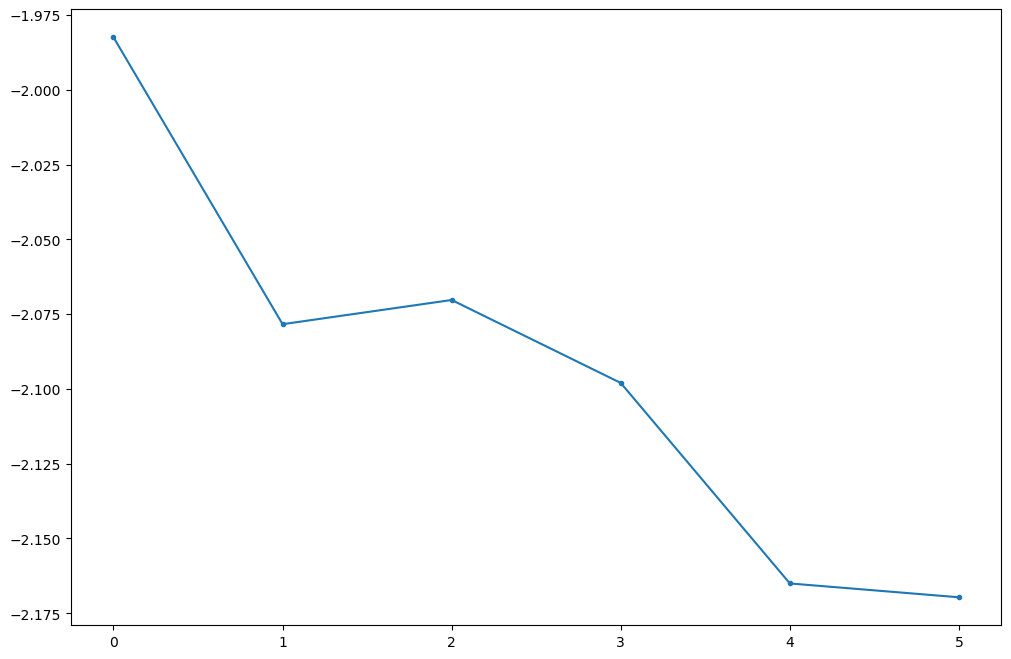

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(input_indices, inputs[0, :, column_indices["T (degC)"]], marker='.')

In [62]:
column_indices["T (degC)"]

1

In [64]:
label_indices

array([6])

In [63]:
labels[0, :, column_indices["T (degC)"]]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.11187895])>

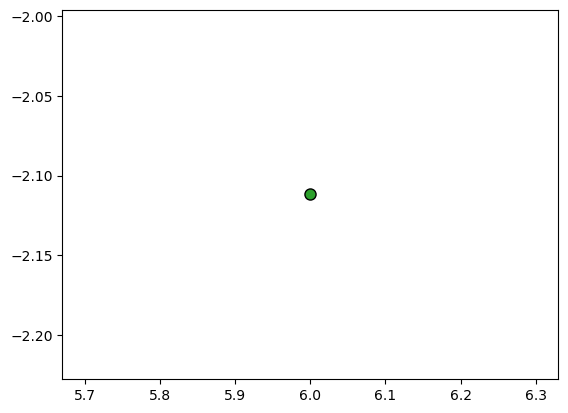

In [69]:
plt.scatter(x=label_indices, y=labels[0, :, column_indices["T (degC)"]],
           edgecolors='k', c="#2ca02c", s=64, label="predictions")

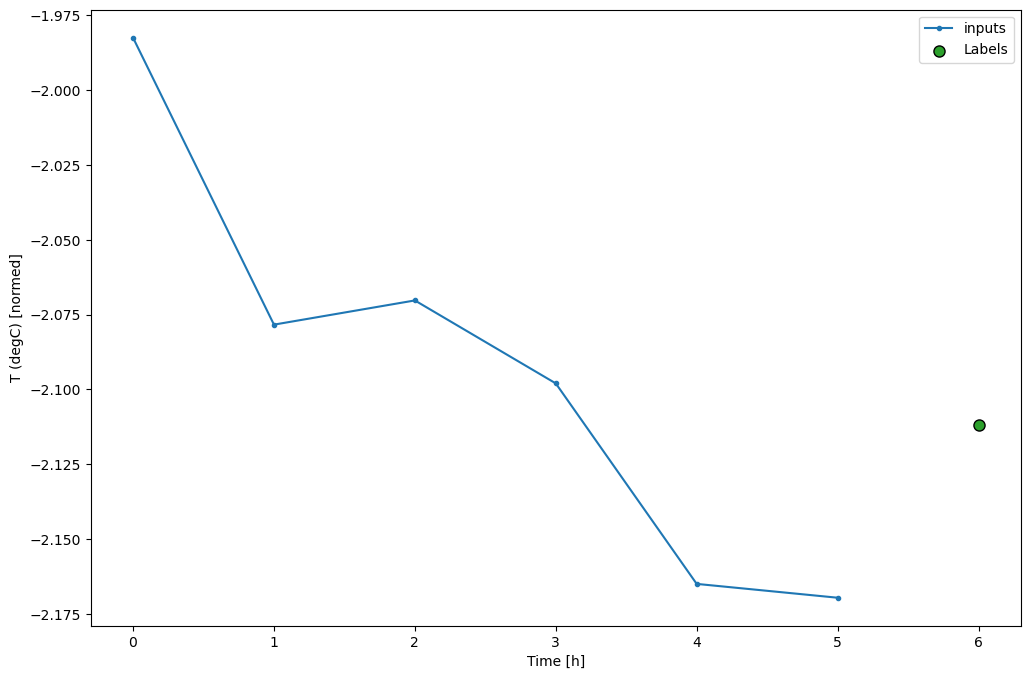

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(input_indices, inputs[0, :, column_indices["T (degC)"]], 
        marker='.', zorder=-10, label="inputs")
plt.scatter(label_indices, labels[0, :, column_indices["T (degC)"]],
           edgecolors='k', c="#2ca02c", s=64, label="Labels")
plt.legend(loc="upper right")
plt.xlabel("Time [h]")
plt.ylabel(f"T (degC) [normed]")
plt.show()